# 1 IMPORTS

In [17]:
import pandas as pd
import os
import sqlalchemy
import dotenv
import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

## 1.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.set_option('display.max_columns', None)
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set()
    
    return None

def postgres_con():
    """
    Connects to mariadb based on .env information
    """
    dotenv.load_dotenv( dotenv.find_dotenv() )
    
    username = os.getenv('USERNAME')
    password = os.getenv('PASSWORD_PA')
    host =     os.getenv('HOST')
    port =     os.getenv('PORT')    
    database = os.getenv('DATABASE')
    
    con = sqlalchemy.create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')
    
    return con

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2 Loading data

In [3]:
# with open('../queries/query_fulltable.sql', 'r') as f:
#     query = f.read()
    
# df_raw = pd.read_sql(query, postgres_con())

# #I will save in csv to prevent from occupying the database everytime I work on the project
# df_raw.to_csv('../data/data_all_clients.csv', index=False)

In [4]:
df_raw = pd.read_csv('../data/data_all_clients.csv')

# 2 DESCRICAO DOS DADOS

## 2.1 Rename Columns

In [6]:
#Not necessary, already in snakecase
df_raw.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

## 2.2 Data Dimensions

In [7]:
print('# of rows:',df_raw.shape[0])
print('# of unique clients:', len(df_raw['id'].unique()))
print('# of rows:',df_raw.shape[1])

# of rows: 381109
# of unique clients: 381109
# of rows: 12


## 2.3 Data Types

In [8]:
df_raw.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 2.4 Check NA

In [9]:
df_raw.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 2.5 Fillout NA

In [10]:
#No NA's founds

## 2.6 Change Data Types

In [11]:
#Data types are according to what's desired.

## 2.7 Descriptive Statistics

In [12]:
num_attributes = df_raw.select_dtypes(include= ['int64', 'float64'])
cat_attributes = df_raw.select_dtypes(exclude= ['int64', 'float64'])

### 2.7.1 Numerical Atributes

In [13]:
d1 = np.mean(num_attributes)
d2 = pd.Series(np.median(num_attributes, axis=0), index=d1.index)
d3 = np.std(num_attributes)
d4 = np.min(num_attributes)
d5 = np.max(num_attributes)
d6 = d5-d4
d7 = pd.Series( skew(num_attributes), index= d1.index)
d8 = pd.Series( kurtosis(num_attributes), index= d1.index)

df_description = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8], axis=1)
df_description.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_description

,mean,median,std,min,max,range,skew,kurtosis
id,"190,555.00","190,555.00","110,016.69",1.00,"381,109.00","381,108.00",0.00,-1.20
previously_insured,0.46,0.00,0.50,0.00,1.00,1.00,0.17,-1.97
annual_premium,"30,564.39","31,669.00","17,213.13","2,630.00","540,165.00","537,535.00",1.77,34.00
vintage,154.35,154.00,83.67,10.00,299.00,289.00,0.00,-1.20
response,0.12,0.00,0.33,0.00,1.00,1.00,2.30,3.30
age,38.82,36.00,15.51,20.00,85.00,65.00,0.67,-0.57
region_code,26.39,28.00,13.23,0.00,52.00,52.00,-0.12,-0.87
policy_sales_channel,112.03,133.00,54.20,1.00,163.00,162.00,-0.90,-0.97
driving_license,1.00,1.00,0.05,0.00,1.00,1.00,-21.60,464.35


### 2.7.2 Categorical Atributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='response'>

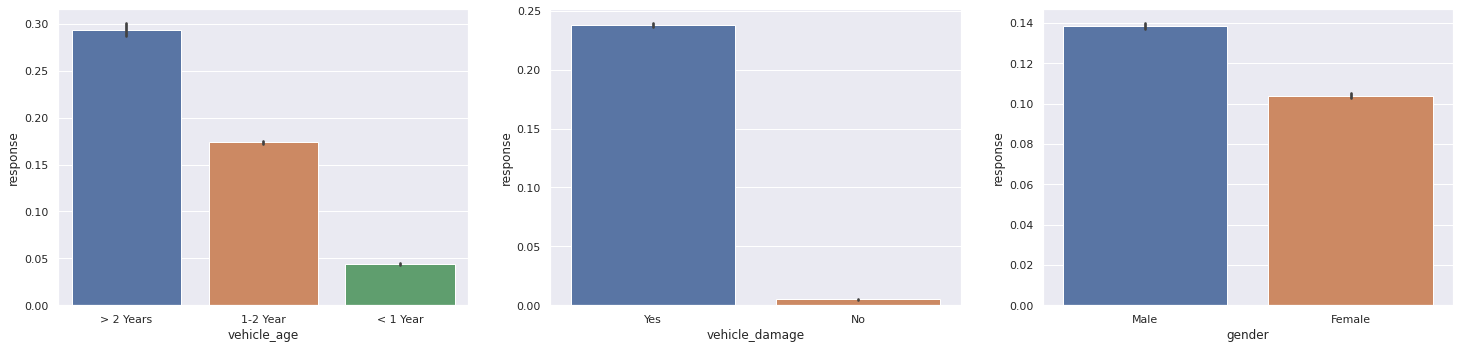

In [15]:
plt.subplot(2,3,1)
sns.barplot(x='vehicle_age',y='response',data=df_raw)

plt.subplot(2,3,2)
sns.barplot(x='vehicle_damage',y='response',data=df_raw)

plt.subplot(2,3,3)
sns.barplot(x='gender',y='response',data=df_raw)

# 3 FEATURE ENGINEERING

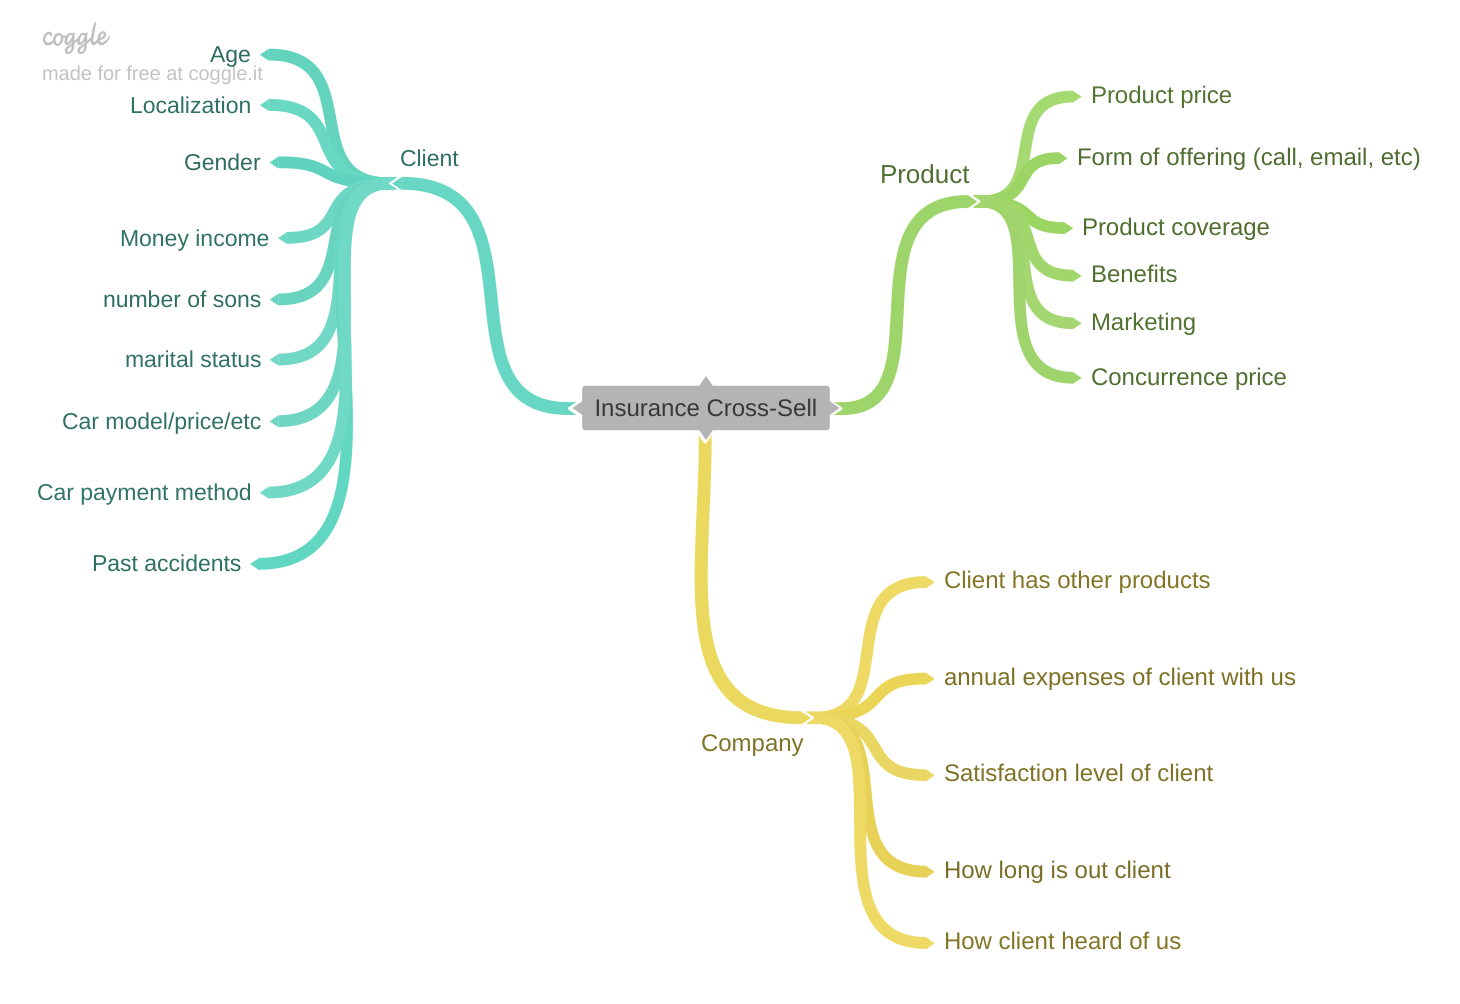

In [21]:
Image('../image/Insurance_Cross-Sell.png')

## 3.1 Business Hypothesis

In [23]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,"40,454.00",217,1,Male,44,28.00,26.00,1,> 2 Years,Yes
1,2,0,"33,536.00",183,0,Male,76,3.00,26.00,1,1-2 Year,No
2,3,0,"38,294.00",27,1,Male,47,28.00,26.00,1,> 2 Years,Yes
3,4,1,"28,619.00",203,0,Male,21,11.00,152.00,1,< 1 Year,No
4,5,1,"27,496.00",39,0,Female,29,41.00,152.00,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,"30,170.00",88,0,Male,74,26.00,26.00,1,1-2 Year,No
381105,381106,1,"40,016.00",131,0,Male,30,37.00,152.00,1,< 1 Year,No
381106,381107,1,"35,118.00",161,0,Male,21,30.00,160.00,1,< 1 Year,No
381107,381108,0,"44,617.00",74,0,Female,68,14.00,124.00,1,> 2 Years,Yes


I will answer the following hypothesis, since they are what I have enough information for answering:

- Customers with vehicle insurance should be less likely to get want our product;
- There should be few policy sales channel that works really well;
- Older people should want more insurance;
- Older clients should accept more the new insurance;
- People without drivers license should not want insurance at all.
- Lower annual premium prices should increase the chance of selling the new product.
- Females should want less insurance than male clients;
- People with older vehicles should want the insurance more.

## 3.2 Feature Engineering

The data set I am working with is very straightforward in this sense, few information can be derived from tha data. For this reason, no new features will be engineered.

# 4 FILTRAGEM DE VARIÁVEIS

## 4.1 Filtragem das Linhas


sla sla

## 4.2 Selecao das Colunas

# 5 ANALISE EXPLORATORIA DOS DADOS

## 5.1 Analise Univariada

### 5.1.1 Response Variable

### 5.1.2 Numerical Variable

### 5.1.3 Categorical Variable

## 5.2 Analise Bivariada

## 5.3 Analise Multivariada

### 5.3.1 Numerical Attributes

### 5.3.2 Categorical Attributes

# 6 DATA PREPARATION

## 6.1 Normalizacao

## 6.2 Rescaling

## 6.3 Transformacao

### 6.3.1 Encoding

### 6.3.2 Response Variable Transformation

### 6.3.3 Nature Transformation

# 7 FEATURE SELECTION

## 7.1 Split dataframe into training and test dataset

## 7.2 Boruta as Feature Selector

### 7.2.1 Best Features from Boruta

## 7.3 Manual Feature Selection

# 8 MACHINE LEARNING MODELLING

## 8.1 Average Model

## 8.2 Linear Regression Model

### 8.2.1 Linear Regression Model - Cross Validation

## 8.3 Linear Regression Regularized Model - Lasso

###  8.3.1 Lasso - Cross Validation

## 8.4 Random Forest Regressor

### 8.4.1 Random Forest Regressor - Cross Validation

## 8.5 XGBoost Regressor

### 8.5.1 XGBoost Regressor - Cross Validation

## 8.6 Compare Model's Performance

### 8.6.1 Single Performance

### 8.6.2 Real Performance - Cross Validation

# 9 HYPERPARAMETER FINE TUNING

## 9.1 Random Search

## 9.2 Final Model

# 10 TRADUCAO E INTERPRETACAO DO ERRO

## 10.1 Business Performance

## 10.2 Total Performance

## 10.3 Machine Learning Performance

# 11 DEPLOY MODEL TO PRODUCTION

## 11.1 Rossmann Class

## 11.2 API Handler

## 11.3 API Tester